# Example 3 A Robust Version of the Normal Model

A more robust version of a normal model is a model based on the Student's t-distribution, which is defined by,

$
\begin{align}
p(t \mid \nu) = \frac{\Gamma\left(\frac{\nu + 1}{2}\right)}{\sqrt{\nu \pi} \, \Gamma\left(\frac{\nu}{2}\right)} \left(1 + \frac{t^2}{\nu}\right)^{-\frac{\nu + 1}{2}}
\end{align}
\tag{1}
$

here $t$ is the random variable and $\nu$ is a parameter representing the degrees of freedom where,

1. **Mean**:
   - For $( \nu > 1 )$: The mean is 0.
   - For $( \nu \leq 1 )$: The mean is undefined.

2. **Variance**:
   - For $( \nu > 2 )$: The variance is $( \frac{\nu}{\nu - 2} )$.
   - For $( 1 < \nu \leq 2 )$: The variance is infinite.
   - For $( \nu \leq 1 )$: The variance is undefined.

3. **Shape**:
   - The t-distribution is symmetric about 0, similar to the normal distribution.
   - It has heavier tails than the normal distribution, which means it gives higher probabilities to extreme values.
   - As $\nu \to \infty$ the t-distribution converges on $\mathcal{N}(0, 1)$
   - For $\nu=1$ the Cauchy Distribution is obtained.

To obtain a $\mathcal{N}(\mu, \sigma)$ in the limit $\nu \to \infty$ make the following transformation,

$
\begin{align}
t^\prime = \sigma t + \mu
\end{align}
\tag{2}
$

Solving for $t$ gives,

$
\begin{align}
t &= \frac{t^\prime - \mu}{\sigma} \\
dt &= \frac{1}{\sigma} dt^\prime \\
\end{align}
\tag{3}
$

It follows that,

$
\begin{align}
p(t^\prime \mid \nu) = \frac{\Gamma\left(\frac{\nu + 1}{2}\right)}{\sigma\sqrt{\nu \pi} \, \Gamma\left(\frac{\nu}{2}\right)} \left(1 + \frac{\left(\frac{t^\prime - \mu}{\sigma}\right)^2}{\nu}\right)^{-\frac{\nu + 1}{2}}
\end{align}
\tag{1}
$


Assume that the parameter priors are given by,

$
\begin{align}
\mu    &\sim \mathcal{U}(l_\mu, h_\mu) \\
\sigma &\sim \mathcal{HN}(\sigma_\sigma) \\
\nu &\sim \mathcal{Exp}(\lambda)
\end{align}
\tag{1}
$

where $\mathcal{U}(l_\mu, h_\mu)$ is a Uniform distribution between $l_\mu$ amd $h_\mu$, $\mathcal{HN}(\sigma_\sigma)$ a HalfNormal distribution with scale $\sigma_\sigma$ and $\mathcal{Exp}(\lambda)$ is an exponential distribution.
The distribution of the data is assumed to have the form,

$
\begin{align}
Y \sim \mathcal{T}(\nu, \mu, \sigma)
\end{align}
\tag{2}
$

Where $\mathcal{T}(\nu, \mu, \sigma)$ with $\nu$ degrees of freedom, location $\mu$ and scale $\sigma$.

It follows that the likelihood function is given by,

$
\begin{align}
P[Y\, | \nu, \mu,\sigma] = \frac{\Gamma\left(\frac{\nu + 1}{2}\right)}{\sigma\sqrt{\nu \pi} \, \Gamma\left(\frac{\nu}{2}\right)} \left(1 + \frac{\left(\frac{t^\prime - \mu}{\sigma}\right)^2}{\nu}\right)^{-\frac{\nu + 1}{2}}
\end{align}
\tag{3}
$

In [1]:
%reload_ext autoreload
%autoreload 2

# import system modules and set local import path
import os
import sys
import numpy
from matplotlib import pyplot
from scipy import stats
import pymc
import arviz

sys.path.insert(0, os.path.abspath('../..'))

from lib import config
from lib.plots import (curve, comparison, scatter, bar, twinx_bar_line, fcurve_scatter_comparison, positive_negative_bar)

pyplot.style.use(config.glyfish_style)

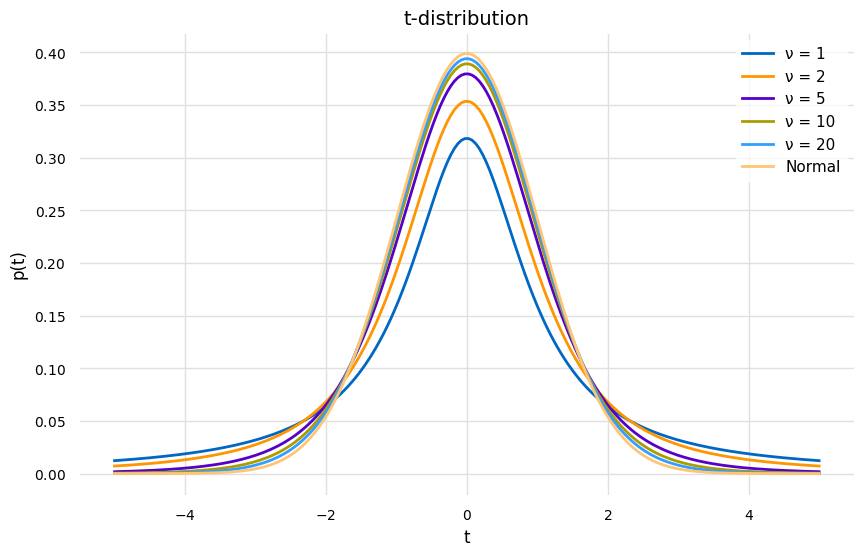

In [2]:
t_vals = numpy.linspace(-5.0, 5.0, 200)
nu_vals = [1, 2, 5, 10, 20]
t_dists = [stats.t.pdf(t_vals, nu, 0, 1) for nu in nu_vals] + [stats.norm.pdf(t_vals, 0, 1)]

labels = [f'ν = {nu}' for nu in nu_vals] + ['Normal']
comparison(t_dists, t_vals, title='t-distribution', xlabel='t', ylabel='p(t)', labels=labels, legend_loc='upper right')

In [3]:
nobs = 100
mu_true = 50
sigma_true = 5
nu_true = 3
t_vals = numpy.linspace(20, 80.0, 200)

l_mu, h_mu = 40, 75
mu_prob = 1.0 / (h_mu - l_mu)
sigma_sigma = 5
nu_lambda = 10.0

mu_vals = numpy.linspace(0, 100, 100)
sigma_vals = numpy.linspace(0.0, 20, 50)
nu_vals = numpy.linspace(0.1, 50, 100)

mu_pdf = numpy.where((mu_vals >= l_mu) & (mu_vals <= h_mu), mu_prob, 0)
sigma_pdf = numpy.abs(stats.norm.pdf(sigma_vals, 0, sigma_sigma))
sigma_pdf = sigma_pdf / sigma_pdf.sum()
nu_pdf = stats.expon.pdf(nu_vals, 0, nu_lambda)
t_pdf = stats.t.pdf(t_vals, nu_true, mu_true, sigma_true)

obs_data = stats.t.rvs(nu_true, mu_true, sigma_true, nobs)

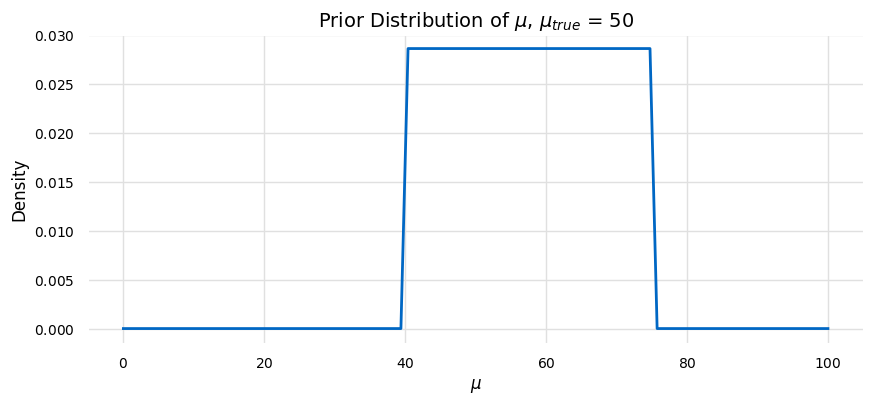

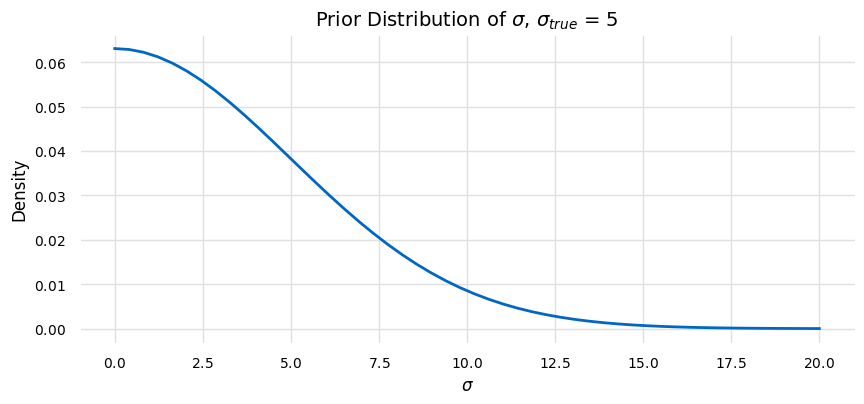

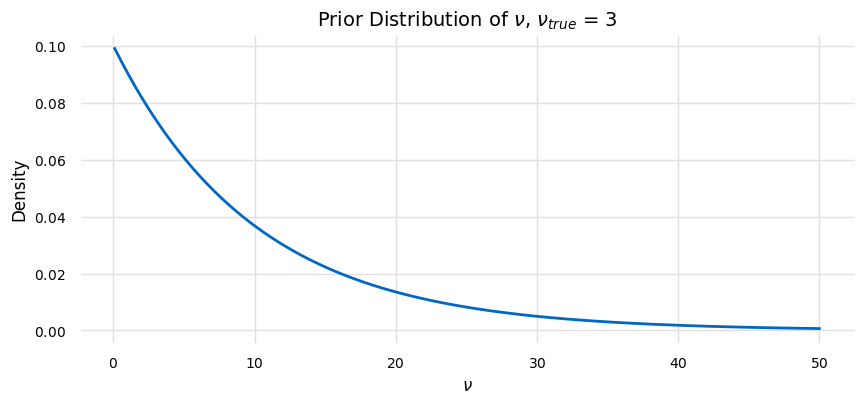

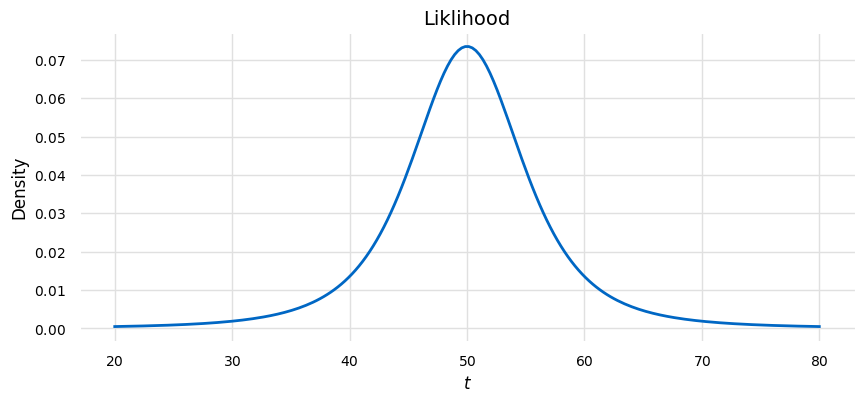

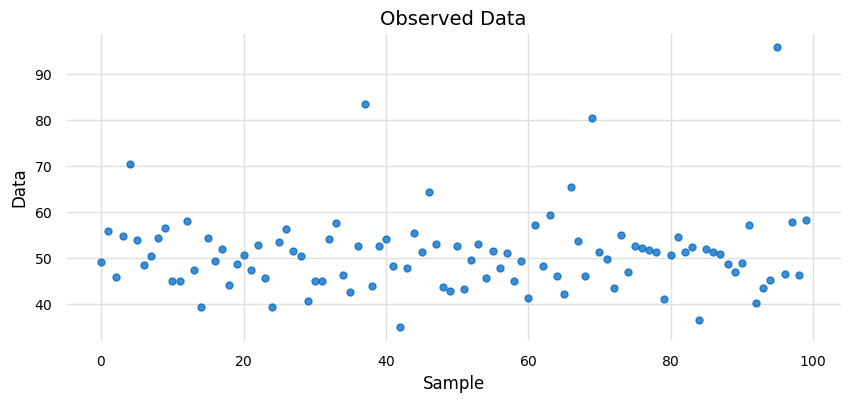

In [4]:
title = f'Prior Distribution of $\mu$, $\mu_{{true}}$ = {mu_true}'
curve(mu_pdf, mu_vals, title=title, xlabel='$\mu$', ylabel='Density', figsize=(10, 4))

title = f'Prior Distribution of $\sigma$, $\sigma_{{true}}$ = {sigma_true}'
curve(sigma_pdf, sigma_vals, title=title, xlabel='$\sigma$', ylabel='Density', figsize=(10, 4))

title = f'Prior Distribution of $\\nu$, $\\nu_{{true}}$ = {nu_true}'
curve(nu_pdf, nu_vals, title=title, xlabel='$\\nu$', ylabel='Density', figsize=(10, 4))

title = f'Liklihood'
curve(t_pdf, t_vals, title=title, xlabel='$t$', ylabel='Density', figsize=(10, 4))

title = f'Observed Data'
scatter(obs_data, numpy.arange(nobs), title=title, xlabel='Sample', ylabel='Data', figsize=(10, 4))

## pyMC

In [5]:
nsample = 1000

with pymc.Model() as model:
    mu = pymc.Uniform('μ', l_mu, h_mu)
    sigma = pymc.HalfNormal('σ', sigma_sigma)
    nu = pymc.Exponential('ν', 1.0 / nu_lambda)
    Y = pymc.StudentT('Y', nu=nu, mu=mu, sigma=sigma, observed=obs_data)
    idata = pymc.sample(nsample, chains=4, target_accept=0.9)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ν]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


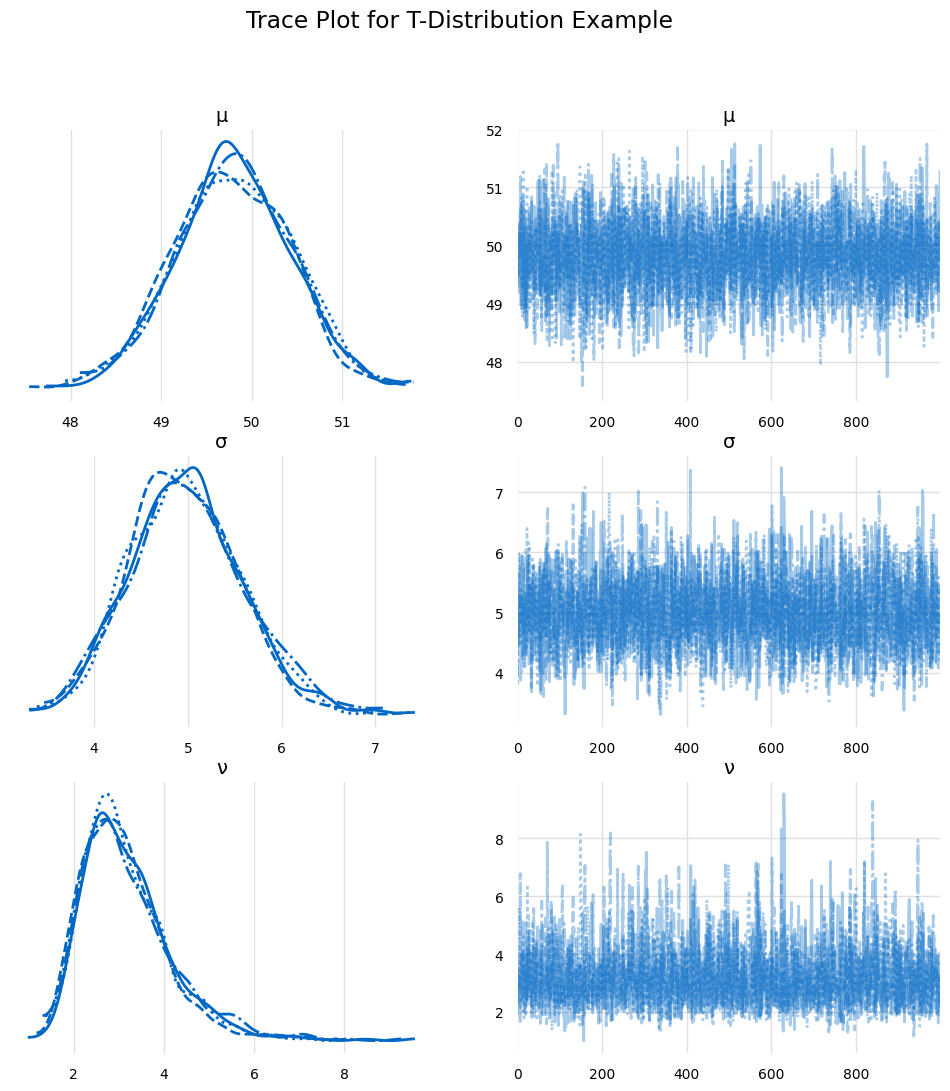

In [6]:
arviz.plot_trace(idata, figsize=(12, 12))
_ = pyplot.suptitle('Trace Plot for T-Distribution Example')

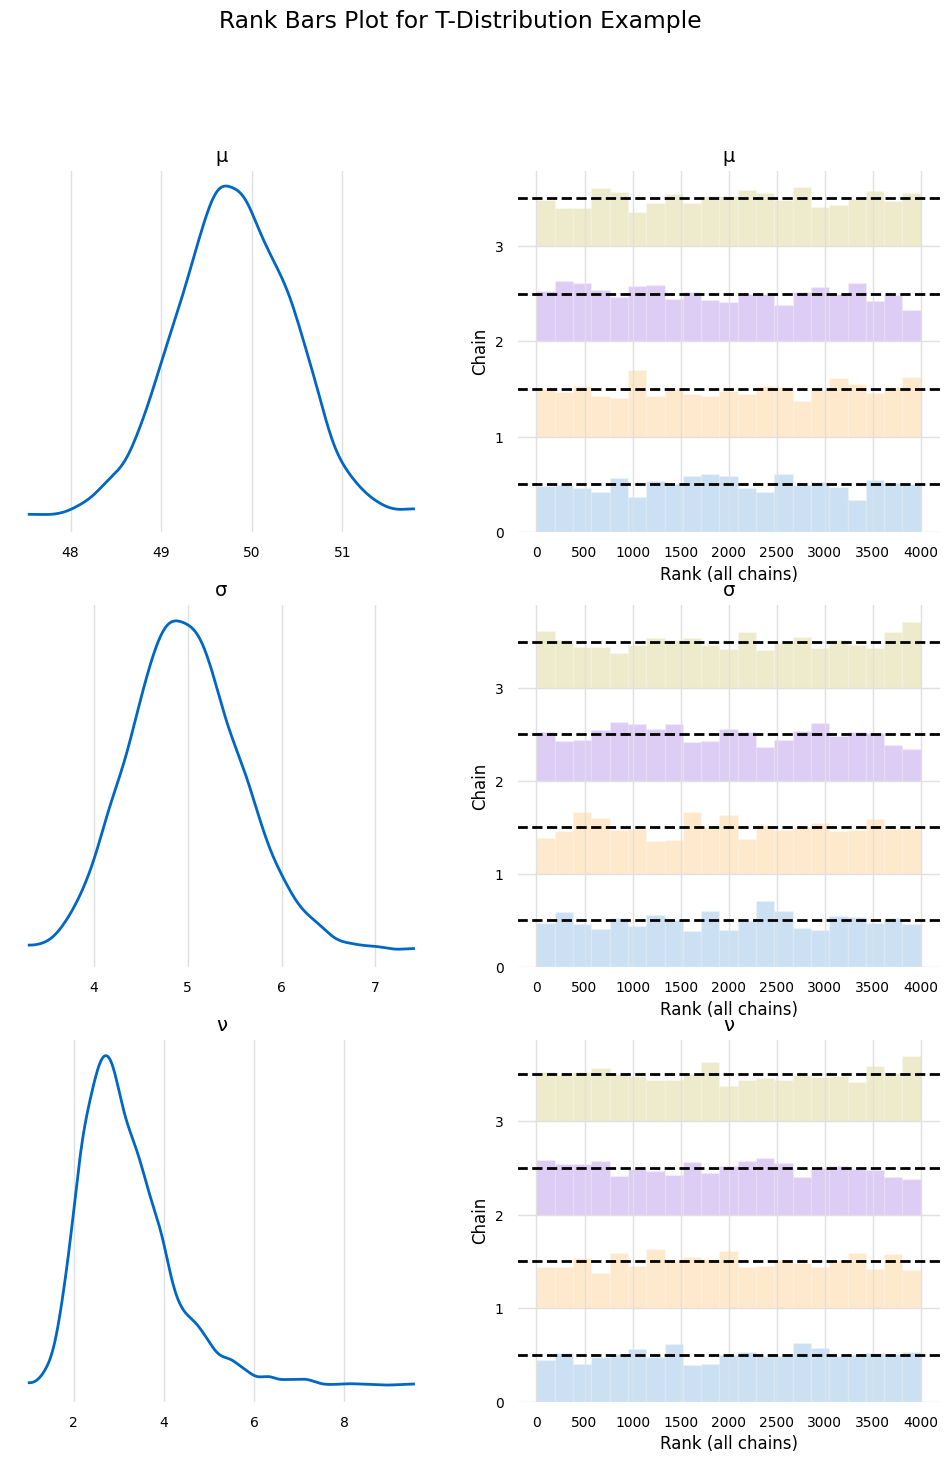

In [7]:
arviz.plot_trace(idata, kind='rank_bars', combined=True, figsize=(12, 16))
_ = pyplot.suptitle('Rank Bars Plot for T-Distribution Example')

In [8]:
arviz.summary(idata).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,49.80,0.63,48.64,50.98,0.01,0.01,2871.0,2755.0,1.0
σ,4.98,0.59,3.87,6.07,0.01,0.01,2399.0,2721.0,1.0
ν,3.16,0.99,1.60,5.00,0.02,0.02,2343.0,2425.0,1.0


In [9]:
_ = pymc.sample_posterior_predictive(idata, model=model, extend_inferencedata=True)

Sampling: [Y]


Output()

(-10.0, 100.0)

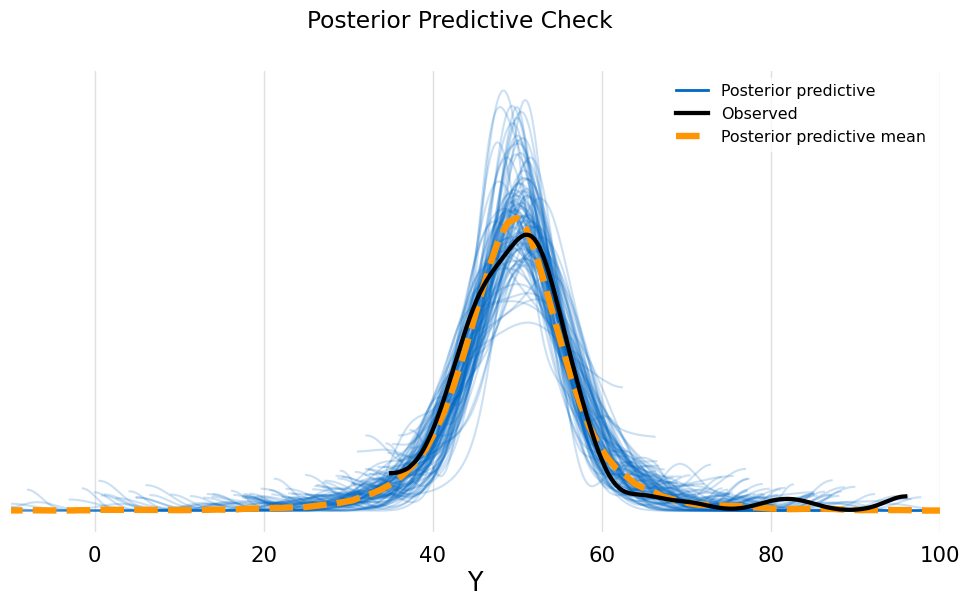

In [10]:
fig, ax = pyplot.subplots(figsize=(12, 6))
arviz.plot_ppc(idata, ax=ax, num_pp_samples=100, figsize=(12, 6))
_ = pyplot.suptitle('Posterior Predictive Check')
ax.set_xlim(-10, 100)

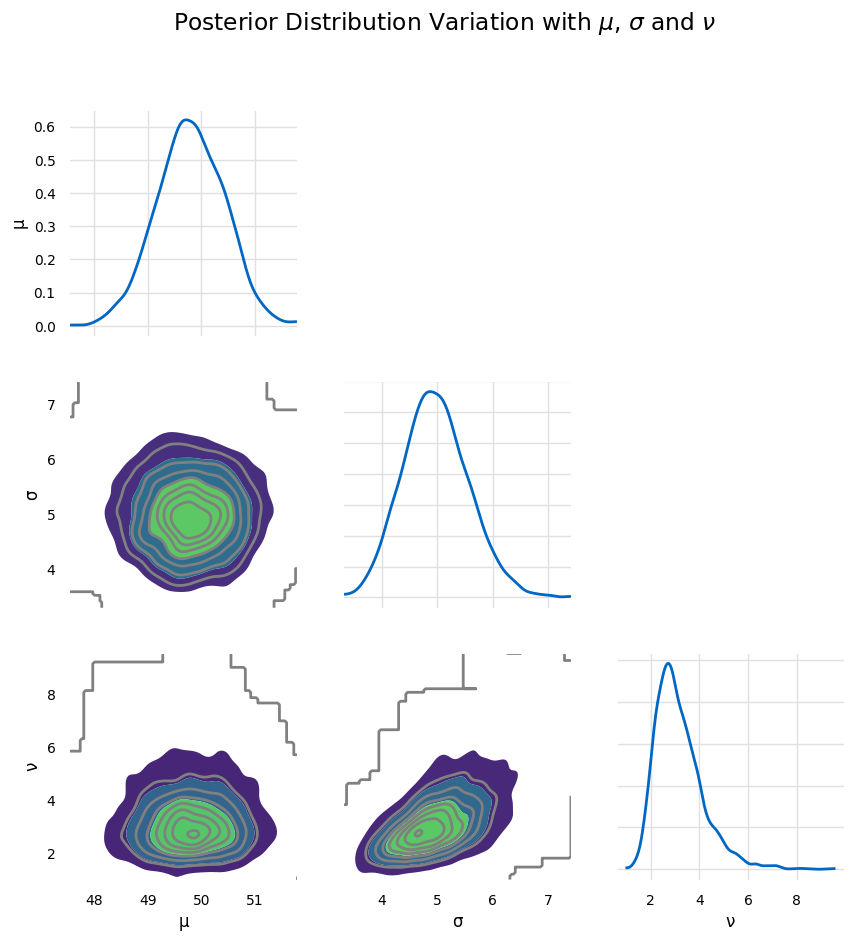

In [11]:
arviz.plot_pair(idata, kind='kde', marginals=True, figsize=(10, 10))
_ = pyplot.suptitle('Posterior Distribution Variation with $\\mu$, $\\sigma$ and $\\nu$')

## Accessing Inference Data

In [12]:
posterior = idata.posterior
posterior

<xarray.Dataset> Size: 104kB
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    μ        (chain, draw) float64 32kB 50.17 49.28 49.32 ... 50.37 49.21 49.51
    σ        (chain, draw) float64 32kB 4.974 5.059 5.635 ... 4.751 4.969 4.896
    ν        (chain, draw) float64 32kB 2.713 2.792 3.457 ... 2.442 2.801 2.323
Attributes:
    created_at:                 2025-01-25T21:37:07.126831+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.19.1
    sampling_time:              1.331441879272461
    tuning_steps:               1000

In [13]:
data = posterior.sel(chain=[0,2], draw=0)
data

<xarray.Dataset> Size: 72B
Dimensions:  (chain: 2)
Coordinates:
  * chain    (chain) int64 16B 0 2
    draw     int64 8B 0
Data variables:
    μ        (chain) float64 16B 50.17 49.36
    σ        (chain) float64 16B 4.974 4.991
    ν        (chain) float64 16B 2.713 2.781
Attributes:
    created_at:                 2025-01-25T21:37:07.126831+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.19.1
    sampling_time:              1.331441879272461
    tuning_steps:               1000

In [14]:
data['σ']

<xarray.DataArray 'σ' (chain: 2)> Size: 16B
array([4.97358439, 4.99068186])
Coordinates:
  * chain    (chain) int64 16B 0 2
    draw     int64 8B 0

In [15]:
data = posterior.sel(draw=slice(0, 10))
data

<xarray.Dataset> Size: 1kB
Dimensions:  (chain: 4, draw: 11)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 88B 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    μ        (chain, draw) float64 352B 50.17 49.28 49.32 ... 49.56 49.55 49.64
    σ        (chain, draw) float64 352B 4.974 5.059 5.635 ... 3.878 4.118 4.018
    ν        (chain, draw) float64 352B 2.713 2.792 3.457 ... 3.234 2.98 2.353
Attributes:
    created_at:                 2025-01-25T21:37:07.126831+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.19.1
    sampling_time:              1.331441879272461
    tuning_steps:               1000

In [16]:
data['μ']

<xarray.DataArray 'μ' (chain: 4, draw: 11)> Size: 352B
array([[50.16779584, 49.27621989, 49.32147593, 50.00290991, 49.51646211,
        49.8755693 , 49.91022297, 50.19332416, 49.9412752 , 48.97071868,
        49.2309679 ],
       [50.29497469, 49.4702083 , 49.98636648, 50.33122514, 50.38847854,
        49.82696147, 50.03977454, 50.42936276, 49.94141565, 49.85762219,
        49.85762219],
       [49.36391745, 50.36535282, 49.3704653 , 50.40785571, 49.48445152,
        50.16533791, 49.18607175, 49.99523669, 51.18566334, 49.10613351,
        48.90458815],
       [50.27625304, 49.94619968, 49.95378913, 49.43242619, 49.71717631,
        49.7452566 , 49.80482609, 50.63849727, 49.56498446, 49.55304421,
        49.64090163]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 88B 0 1 2 3 4 5 6 7 8 9 10

In [17]:
posterior.mean()

<xarray.Dataset> Size: 24B
Dimensions:  ()
Data variables:
    μ        float64 8B 49.8
    σ        float64 8B 4.98
    ν        float64 8B 3.16

In [18]:
posterior.mean('draw')

<xarray.Dataset> Size: 128B
Dimensions:  (chain: 4)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
Data variables:
    μ        (chain) float64 32B 49.8 49.81 49.75 49.82
    σ        (chain) float64 32B 4.987 4.979 4.948 5.007
    ν        (chain) float64 32B 3.194 3.145 3.099 3.204

In [19]:
arviz.extract(idata, num_samples=10)

<xarray.Dataset> Size: 480B
Dimensions:  (sample: 10)
Coordinates:
  * sample   (sample) object 80B MultiIndex
  * chain    (sample) int64 80B 3 3 3 2 2 2 2 1 2 2
  * draw     (sample) int64 80B 560 429 761 389 375 465 433 456 755 231
Data variables:
    μ        (sample) float64 80B 49.81 49.54 49.09 49.79 ... 49.41 49.67 50.97
    σ        (sample) float64 80B 4.444 5.78 4.451 5.557 ... 5.566 4.44 5.126
    ν        (sample) float64 80B 3.397 5.28 2.225 2.796 ... 3.669 2.695 3.903
Attributes:
    created_at:                 2025-01-25T21:37:07.126831+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.19.1
    sampling_time:              1.331441879272461
    tuning_steps:               1000